# paper: FRB 220418aaai (SN10.4)

In [49]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn, sgram_fn_vec, sgram_fn, gauss, gauss_norm, model_free_4, model_free_normalized_4, power_law # pulse_fn_vec  
from burstfit.utils.plotter import plot_fit_results, plot_2d_fit 
from burstfit.io import BurstIO
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
# use Liam's function to read in filterbank files 
import sys
sys.path.insert(1, '/home/ubuntu/gechen/software')
import filplot_funcs_gc as ff

 
%matplotlib inline 

def prepare_bd(candidate, dm_heimdall, width_heimdall, snr_heimdall, mask_chans=[], 
               datestring=None, beam=None, corr=None, fil_file=None, voltage = False):
    if voltage: 
        fil_file = fil_file
    else: 
        fil_file ='/data/dsa110/T1/'+corr + '/' + datestring + '/fil_'+candidate+'/'+candidate+'_'+str(beam)+'.fil'
    
    logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
    logging.basicConfig(
        level=logging.INFO,
        format=logging_format,
    )
    
    bd = BurstData(
    fp=fil_file,
    dm=dm_heimdall ,
    tcand=0.5, # pulse starting time in s.
    width=width_heimdall,  
    snr=snr_heimdall
    )

    bd.prepare_data(mask_chans = mask_chans)
    
    return bd, fil_file




# input variables 
candidate = '220418aaai'
datestring = '2022_4_18_4_58_12'
beam = 66
corr = 'corr02'
dm_heimdall = 623.45 #624.1
width_heimdall = 4 
snr_heimdall = 10.4
mask_chans=[] 
fil_file = "/home/ubuntu/vikram/scratch/220418aaai.fil"

voltage = True
dedisperse=True

bd, fil_file = prepare_bd(candidate, dm_heimdall, width_heimdall, 
                          snr_heimdall, datestring=datestring, beam=beam, 
                          corr=corr, fil_file=fil_file, voltage=voltage)



2022-06-01 23:42:24,510 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2022-06-01 23:42:30,253 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2022-06-01 23:42:30,257 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2022-06-01 23:42:32,118 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (49.5635093350566, 35.18433633225558)


## de-disperse data (or read from file) and chop near the burst time

In [ ]:
def prepare_burst_data(filterbank, candidate, bd, voltage = True, t_chop_center_s = 0.5, t_chop_width = 50, dedisperse=dedisperse, nfreq = 4):
    
    # save the de-dispersed data to file (de-dispersion takes long time)
    if dedisperse:
        data = ff.proc_cand_fil(filterbank, bd.dm, bd.width, nfreq_plot=nfreq, ndm=64)[0]
        if voltage: 
            np.save('%s_%d_voltage.txt'%(candidate, nfreq), data, allow_pickle=False)
        else: 
            np.save('%s_%d.txt'%(candidate, nfreq), data, allow_pickle=False)
    else: 
        data = np.load('%s_%d.txt.npy'%(candidate, nfreq)) 
    
    
    i_low = int(t_chop_center_s / bd.tsamp - t_chop_width * bd.width)
    i_high = int(t_chop_center_s / bd.tsamp + t_chop_width * bd.width)
    
    t_burst = [i * bd.tsamp * 1e3 for i in range(i_low, i_high)]
    data_burst = data[:, i_low: i_high] 

    fig1, ax1 = plt.subplots(1, 2, figsize=(12, 5)) 
    ax1[0].plot(t_burst, data_burst.mean(0))
    ax1[0].set_xlabel('Time (ms)')
    ax1[1].plot(data_burst.mean(1))
    ax1[1].set_xlabel('Binned channel')
    ax1[1].set_title('bin freq channel #%d'%nfreq)
    plt.tight_layout()
    
    
    return data_burst




data_burst = prepare_burst_data(fil_file, candidate, bd, voltage = voltage, dedisperse=dedisperse, t_chop_center_s=0.5, t_chop_width = 10)




## Fit, select model, spectrum autocorrlation

In [46]:
def fit_paper_curvefit(data_2d, pnames, pulse_Model, profile_bounds, snames, spectra_Model, nfreq = 4, fix_ncomp=False, ncomp=1, plot=True):
    ncomp = ncomp
    pnames = pnames 
    pulseModel = Model(pulse_Model, param_names=pnames)
    spectraModel = Model(spectra_Model, param_names=snames)
    sgram_mask = np.full(np.shape(data_2d), False)
    sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)
    
    bf = BurstFit(
    sgram_model=sgramModel,
    sgram=data_2d, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1,
    )
    
    bf.validate()
    bf.precalc()
    #bf.initial_profilefit(bounds = profile_bounds, plot = plot)
    #bf.initial_spectrafit(plot = plot)

    #bf.fitcycle(plot=plot) # fit for one component.
    bf.fitall(plot=plot, fix_ncomp = fix_ncomp, ncomp = ncomp) # fit all componnts 
    print('{bf}.calc_redchisq()=', bf.calc_redchisq())


    # plot_fit_results(bf_S1T2_c1.sgram, bf_S1T2_c1.sgram_model.evaluate, bf_S1T2_c1.sgram_params['all'][1]['popt'], 
    #                  bf_S1T2_c1.tsamp, bf_S1T2_c1.fch1, bf_S1T2_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
    #dm_fit, dm_fit_err = bf_S1T2_c1.sgram_params['all'][1]['popt'][-1], bf_S1T2_c1.sgram_params['all'][1]['perr'][-1]

    return bf 


def fit_paper_mcmc_bic(bf, mcmc=True, nwalkers = 60, nsteps = 5000, n_param_overlap = 0):
    mcmc_kwargs = {'nwalkers':nwalkers, 'nsteps':nsteps,
               'skip':500, 'ncores':4, 
               'start_pos_dev':0.01,
               'prior_range':0.8, 
               'save_results':True,
               'outname':'test_file'}

    if mcmc:
        bf.run_mcmc(plot=True, **mcmc_kwargs)
    
    n_model_param = bf.comp_num * len(bf.param_names) - n_param_overlap 
    n_data = bf.nt * bf.nf 
    model_param = []
    for i in range(1, bf.comp_num + 1):
        model_param += bf.sgram_params['all'][i]['popt'] 

    lnL = bf.mcmc.lnlk(model_param)
    bf.BIC(lnL, n_model_param, n_data)
    print('{bf}.bic = ', bf.bic) 
    
    return 0


def select_model(bf_name_list):
    bic_list = []
    for name in bf_name_list:
        bf = globals()[name]
        bic_list = np.append(bic_list, bf.bic)
        
    return [x for _,x in sorted(zip(bic_list, bf_name_list))], bic_list


def autocorrelation():
    pass

self.function_input_names:  ['S', 'mu', 'sigma']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 20:49:20,306 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 20:49:20,309 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 20:49:20,314 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-26 20:49:20,316 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 20:49:20,320 - tests -root - INFO - P values: T-test (0.00158), Kruskal (0.00866), KS (0.02141), F-test (0.00515)
2022-05-26 20:49:20,322 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 20:49:20,325 - tests -root - INFO - P values: T-test (0.00002), Kruskal (0.00005), KS (0.00151), F-test (0.00008)
2022-05-26 20:49:20,327 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-26 20:49:20,328 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-26 20:49:20,334 - initial_profilefi

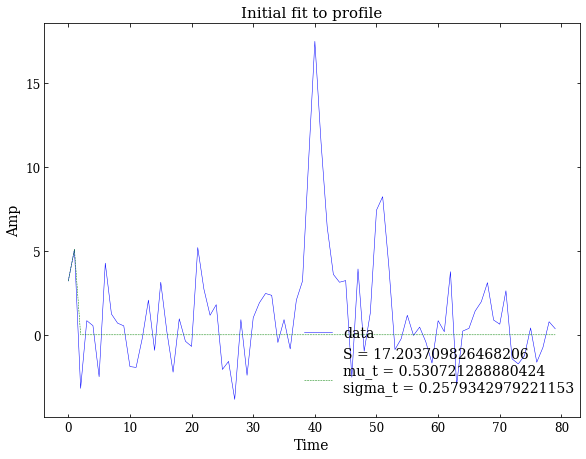

2022-05-26 20:49:20,492 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 20:49:20,495 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f9f3dc02d90>
[0.25922593 0.44644463 0.34743473 0.15301532]


2022-05-26 20:49:20,506 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 20:49:20,510 - initial_spectrafit -burstfit.fit - INFO - c0: 0.2592259347438812 +- 0.0
2022-05-26 20:49:20,512 - initial_spectrafit -burstfit.fit - INFO - c1: 0.44644463062286377 +- 0.0
2022-05-26 20:49:20,514 - initial_spectrafit -burstfit.fit - INFO - c2: 0.34743472933769226 +- 0.0


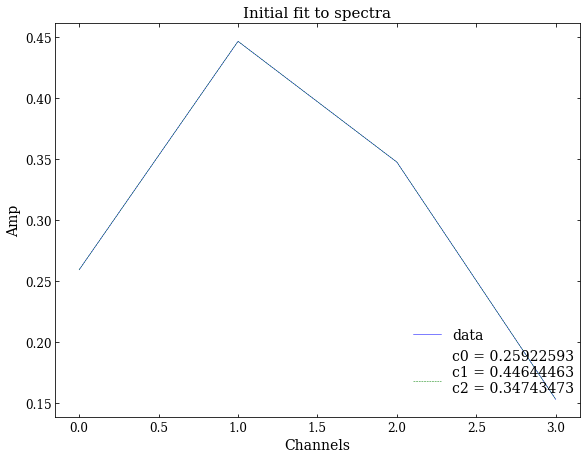

2022-05-26 20:49:20,722 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 20:49:20,724 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.25922593, 0.44644463, 0.34743473, 17.203709826468206, 0.530721288880424, 0.2579342979221153, 624.1]
/home/ubuntu/anaconda3/envs/casa/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2022-05-26 20:49:20,994 - run_fit -burstfit.curvefit - WARNING - Fit errors are not finite. Retrying with p0+-(0.2*p0) bounds
2022-05-26 20:49:21,103 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 20:49:21,105 - sgram_fit -burstfit.fit - INFO - c0: 0.23746134816554545 +- 0.2567116457229885
2022-05-26 20:49:21,106 - sgram_fit -burstfit.fit - INFO - c1: 0.48298517634279725 +- 0.20972666921980038
2022-05-26 20:49:21,112 - sgram_fit -burstfit.fit - INFO - c2: 0.3221017605803266 +- 0.20992

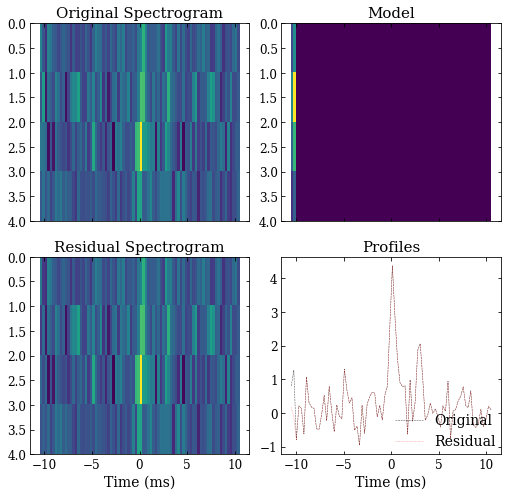

2022-05-26 20:49:21,536 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:49:21,540 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:49:21,545 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 20:49:21,549 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 20:49:21,551 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:49:21,553 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:49:21,558 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0574486644925647
2022-05-26 20:49:21,560 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 20:49:21,561 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 20:49:21,565 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-26 20:49:21,567 - run

ValueError: Data passed to ks_2samp must not be empty

In [10]:
bf_S1T1_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t'], gauss, 
          [(0, 30, 0),(np.inf, 60, 5*bd.width)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, ncomp=1, plot=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 20:53:10,622 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 20:53:10,625 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 20:53:10,629 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-26 20:53:10,630 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 20:53:10,634 - tests -root - INFO - P values: T-test (0.00158), Kruskal (0.00866), KS (0.02141), F-test (0.00515)
2022-05-26 20:53:10,636 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 20:53:10,640 - tests -root - INFO - P values: T-test (0.00002), Kruskal (0.00005), KS (0.00151), F-test (0.00008)
2022-05-26 20:53:10,642 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-26 20:53:10,644 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-26 20:53:10,666 - initial_profilefi

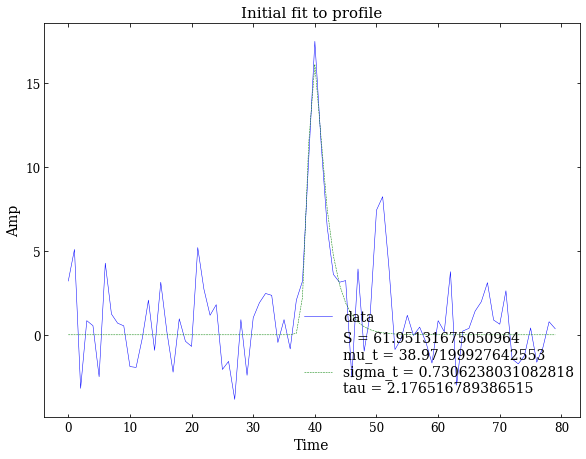

2022-05-26 20:53:10,854 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 20:53:10,857 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f9f3dc02d90>
[0.18606967 0.2985075  0.5038143  0.20928691]


2022-05-26 20:53:10,864 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 20:53:10,867 - initial_spectrafit -burstfit.fit - INFO - c0: 0.18606966733932495 +- 0.0
2022-05-26 20:53:10,869 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2985075116157532 +- 0.0
2022-05-26 20:53:10,870 - initial_spectrafit -burstfit.fit - INFO - c2: 0.5038142800331116 +- 0.0


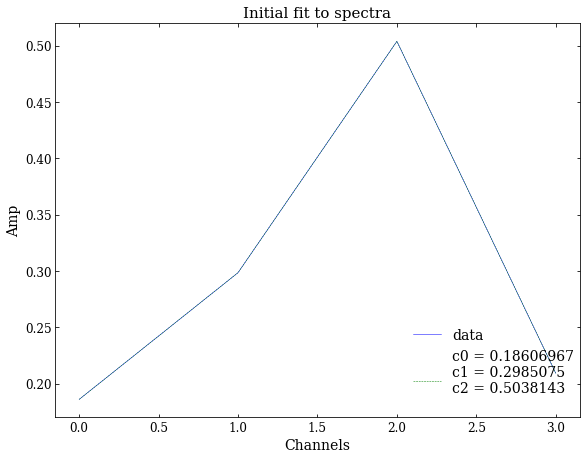

2022-05-26 20:53:11,054 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 20:53:11,056 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.18606967, 0.2985075, 0.5038143, 61.95131675050964, 38.97199927642553, 0.7306238031082818, 2.176516789386515, 624.1]
2022-05-26 20:53:11,385 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 20:53:11,389 - sgram_fit -burstfit.fit - INFO - c0: 0.19611860509386805 +- 0.05093141756642197
2022-05-26 20:53:11,391 - sgram_fit -burstfit.fit - INFO - c1: 0.32148209739851275 +- 0.05091928600656797
2022-05-26 20:53:11,393 - sgram_fit -burstfit.fit - INFO - c2: 0.4700986053920509 +- 0.04663982280972829
2022-05-26 20:53:11,396 - sgram_fit -burstfit.fit - INFO - S: 57.71436583903671 +- 2.1411615310973513
2022-05-26 20:53:11,398 - sgram_fit -burstfit.fit - INFO - mu_t: 39.436422319089885 +- 0.3455530157402994
2022-05-26 20:53:11,400 - sgram_fit -burstfit.fit - INFO - sigma_t: 0.8166448

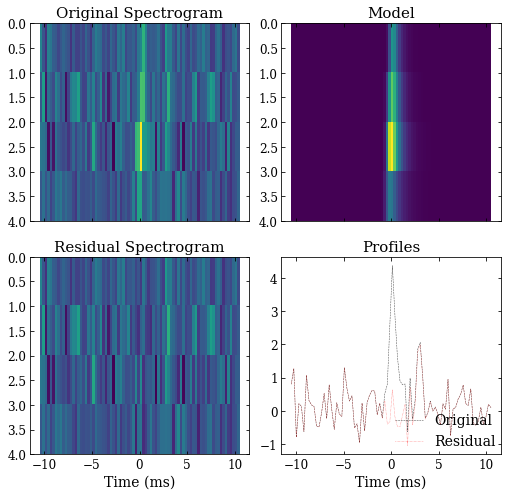

2022-05-26 20:53:11,737 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:53:11,740 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:53:11,744 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 20:53:11,746 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 20:53:11,748 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:53:11,750 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:53:11,753 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.022610483782014
2022-05-26 20:53:11,755 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-26 20:53:11,757 - fitall -burstfit.fit - INFO - Final number of components = 1. Terminating fitting.
2022-05-26 20:53:11,759 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to 

{bf}.calc_redchisq()= 1.022610483782014


In [11]:
bf_S1T2_c1 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 30, 0, 0),(np.inf, 60, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=1, plot=True)

2022-05-26 20:53:33,697 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-26 20:53:33,702 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [1.96118605e-01 3.21482097e-01 4.70098605e-01 5.77143658e+01
 3.94364223e+01 8.16644897e-01 1.90535993e+00 6.23425789e+02]
2022-05-26 20:53:33,705 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-26 20:53:33,707 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-26 20:53:33,709 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-26 20:53:33,711 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(3.429647878023077) + max_sigma_t_prior(1.4699608140731486))
2022-05-26 20:53:33,713 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its max value of prior to 500*max(ts)*

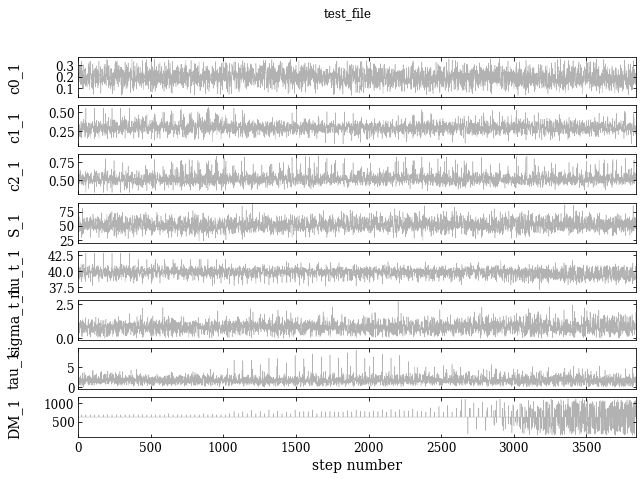

<Figure size 432x288 with 0 Axes>

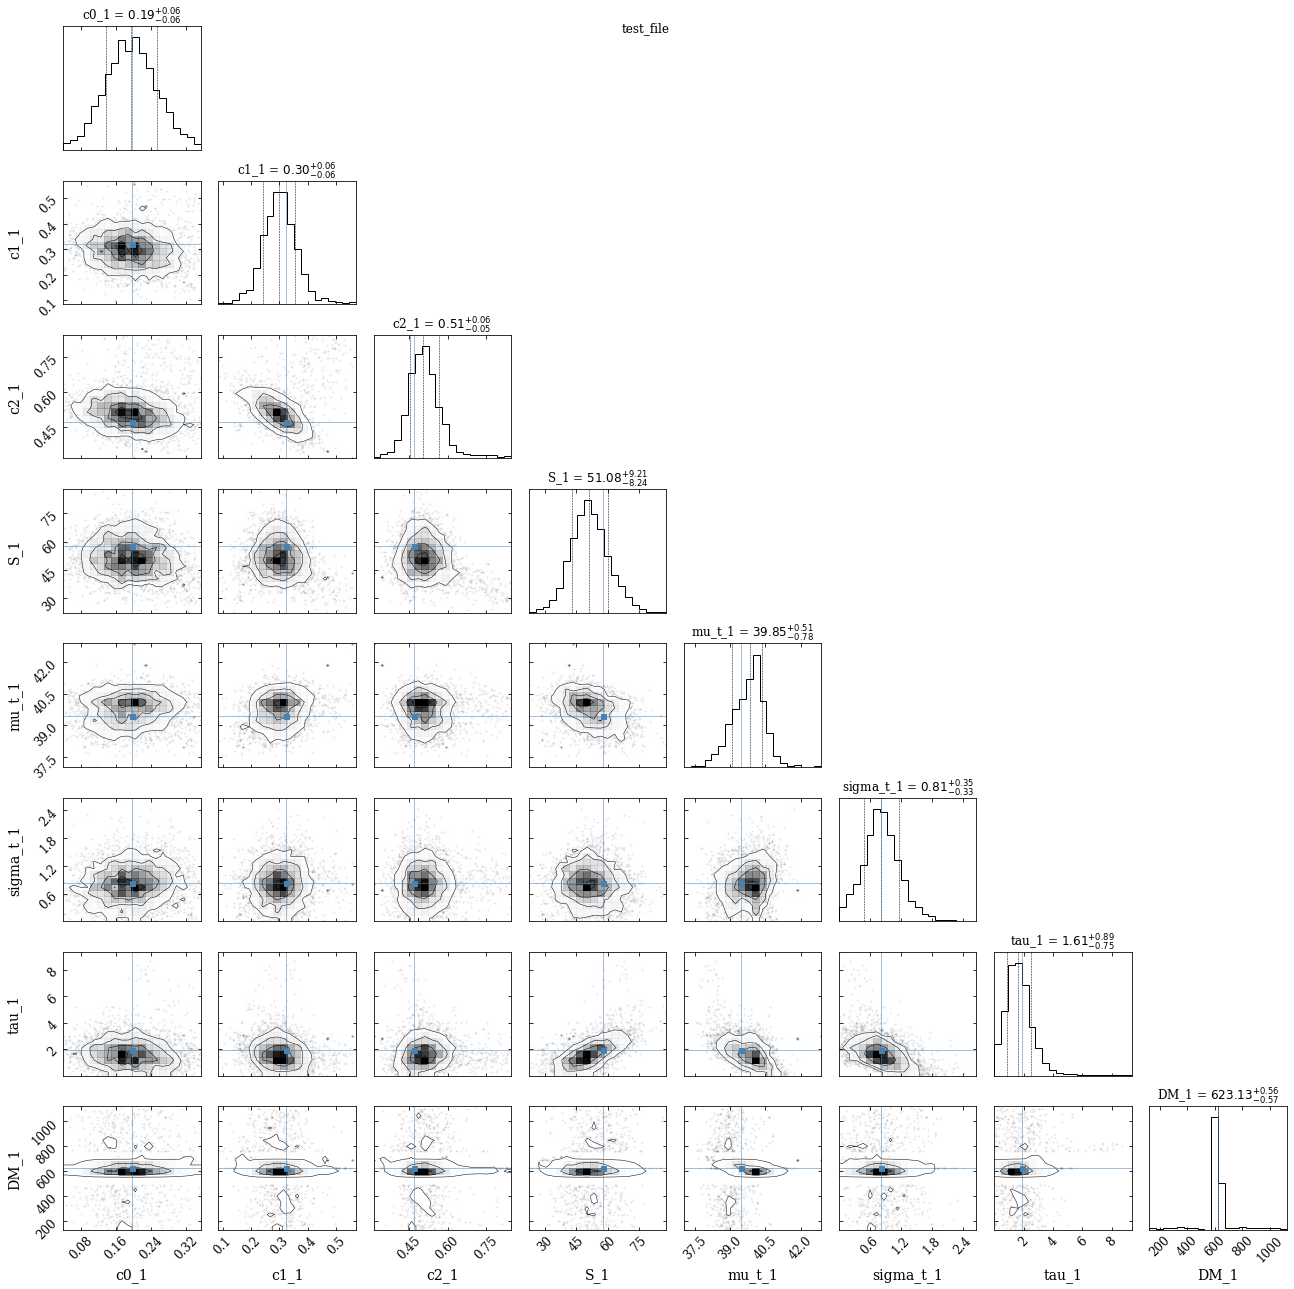

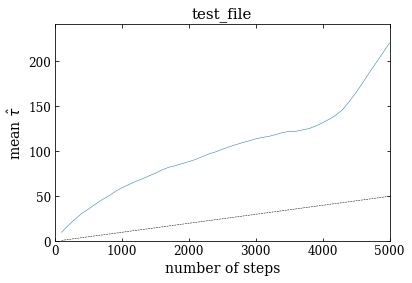

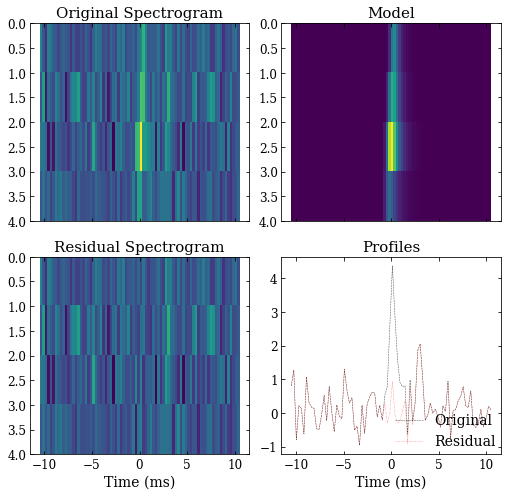

{bf}.bic =  275.7549289161843


0

In [12]:
fit_paper_mcmc_bic(bf_S1T2_c1, mcmc=True)

self.function_input_names:  ['S', 'mu', 'sigma', 'tau']
self.function_input_names:  ['c0', 'c1', 'c2']


2022-05-26 20:57:18,474 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 20:57:18,476 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 20:57:18,479 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-26 20:57:18,481 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2022-05-26 20:57:18,485 - tests -root - INFO - P values: T-test (0.00158), Kruskal (0.00866), KS (0.02141), F-test (0.00515)
2022-05-26 20:57:18,487 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2022-05-26 20:57:18,491 - tests -root - INFO - P values: T-test (0.00002), Kruskal (0.00005), KS (0.00151), F-test (0.00008)
2022-05-26 20:57:18,493 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2022-05-26 20:57:18,495 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2022-05-26 20:57:18,517 - initial_profilefi

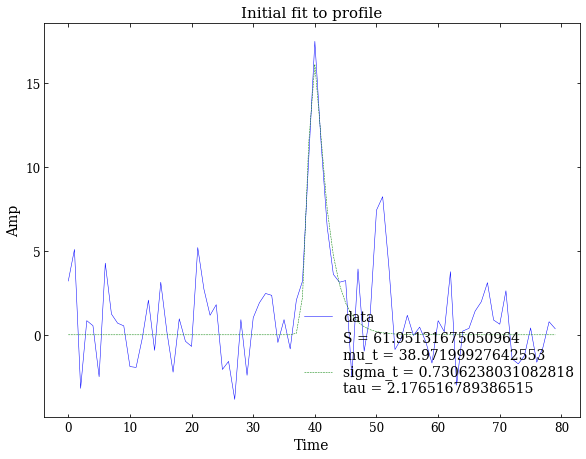

2022-05-26 20:57:18,717 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 20:57:18,720 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 1


<function model_free_normalized_4 at 0x7f9f3dc02d90>
[0.18606967 0.2985075  0.5038143  0.20928691]


2022-05-26 20:57:18,728 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 20:57:18,730 - initial_spectrafit -burstfit.fit - INFO - c0: 0.18606966733932495 +- 0.0
2022-05-26 20:57:18,732 - initial_spectrafit -burstfit.fit - INFO - c1: 0.2985075116157532 +- 0.0
2022-05-26 20:57:18,735 - initial_spectrafit -burstfit.fit - INFO - c2: 0.5038142800331116 +- 0.0


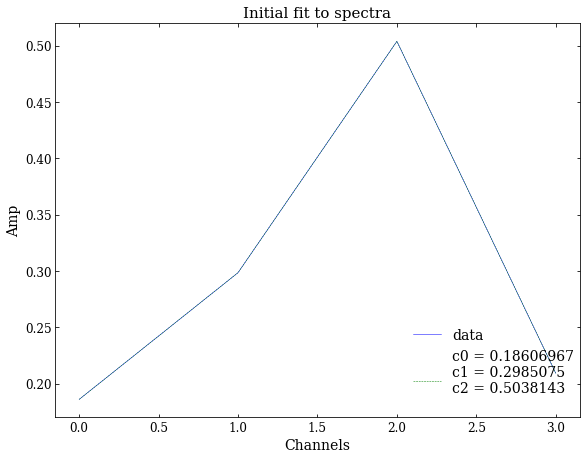

2022-05-26 20:57:18,905 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 1
2022-05-26 20:57:18,908 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.18606967, 0.2985075, 0.5038143, 61.95131675050964, 38.97199927642553, 0.7306238031082818, 2.176516789386515, 624.1]
2022-05-26 20:57:19,248 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 20:57:19,251 - sgram_fit -burstfit.fit - INFO - c0: 0.19611860509386805 +- 0.05093141756642197
2022-05-26 20:57:19,253 - sgram_fit -burstfit.fit - INFO - c1: 0.32148209739851275 +- 0.05091928600656797
2022-05-26 20:57:19,256 - sgram_fit -burstfit.fit - INFO - c2: 0.4700986053920509 +- 0.04663982280972829
2022-05-26 20:57:19,259 - sgram_fit -burstfit.fit - INFO - S: 57.71436583903671 +- 2.1411615310973513
2022-05-26 20:57:19,262 - sgram_fit -burstfit.fit - INFO - mu_t: 39.436422319089885 +- 0.3455530157402994
2022-05-26 20:57:19,265 - sgram_fit -burstfit.fit - INFO - sigma_t: 0.8166448

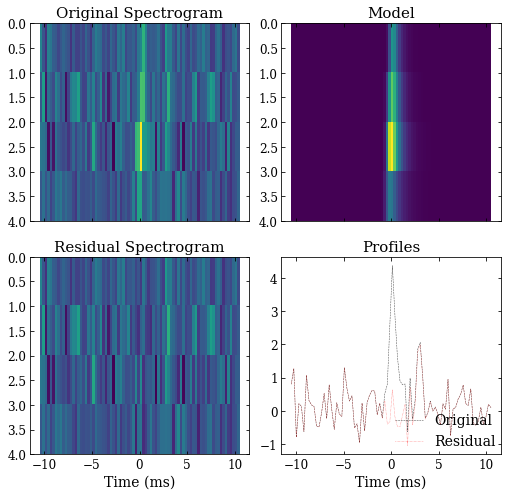

2022-05-26 20:57:19,672 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:19,675 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:57:19,679 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 20:57:19,682 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 20:57:19,684 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:19,686 - model -burstfit.fit - INFO - Found 1 components.
2022-05-26 20:57:19,689 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.022610483782014
2022-05-26 20:57:19,691 - fitcycle -burstfit.fit - INFO - Fitting component 2.
2022-05-26 20:57:19,693 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 2
2022-05-26 20:57:19,718 - initial_profilefit -burstfit.fit - INFO - Converged parameters (profile fit) are:
2022-05-26 20:57:19,721 - initial_profilefit -burst

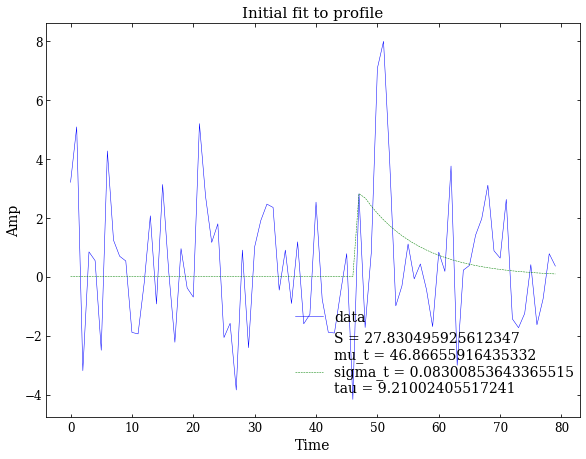

2022-05-26 20:57:19,919 - make_spectra -burstfit.fit - INFO - Making spectra using profile fit parameters.
2022-05-26 20:57:19,922 - initial_spectrafit -burstfit.fit - INFO - Running spectra profile fit for component: 2


<function model_free_normalized_4 at 0x7f9f3dc02d90>
[0.42053202325049255 0.45294981264909295 0.15115832015953243
 0.3712517111322568]


2022-05-26 20:57:19,928 - initial_spectrafit -burstfit.fit - INFO - Converged parameters (spectra fit) are:
2022-05-26 20:57:19,930 - initial_spectrafit -burstfit.fit - INFO - c0: 0.42053202325049255 +- 0.0
2022-05-26 20:57:19,932 - initial_spectrafit -burstfit.fit - INFO - c1: 0.45294981264909295 +- 0.0
2022-05-26 20:57:19,933 - initial_spectrafit -burstfit.fit - INFO - c2: 0.15115832015953243 +- 0.0


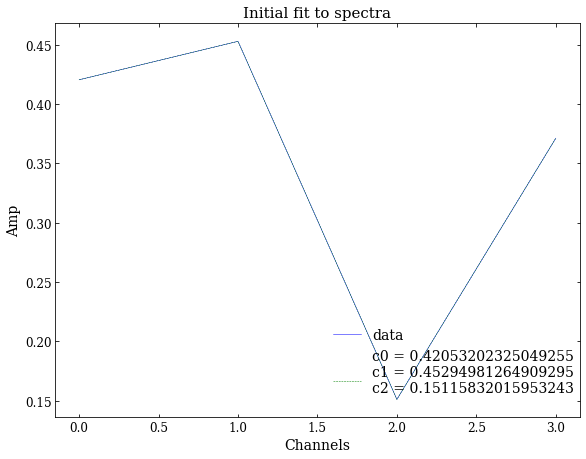

2022-05-26 20:57:20,112 - sgram_fit -burstfit.fit - INFO - Running sgram profile fit for component: 2
2022-05-26 20:57:20,115 - sgram_fit -burstfit.fit - INFO - initial estimate for parameters: [0.42053202325049255, 0.45294981264909295, 0.15115832015953243, 27.830495925612347, 46.86655916435332, 0.08300853643365515, 9.21002405517241, 624.1]
2022-05-26 20:57:20,152 - sgram_fit -burstfit.fit - INFO - Converged parameters are:
2022-05-26 20:57:20,155 - sgram_fit -burstfit.fit - INFO - c0: 0.3077574563986789 +- 0.2596273698124814
2022-05-26 20:57:20,157 - sgram_fit -burstfit.fit - INFO - c1: 0.4803009334784751 +- 0.2104685008091125
2022-05-26 20:57:20,160 - sgram_fit -burstfit.fit - INFO - c2: 0.1495952712930959 +- 0.2415842304574716
2022-05-26 20:57:20,162 - sgram_fit -burstfit.fit - INFO - S: 18.92323715076114 +- 4.4817290373431335
2022-05-26 20:57:20,164 - sgram_fit -burstfit.fit - INFO - mu_t: 46.368905990626544 +- 4.306266496598386
2022-05-26 20:57:20,166 - sgram_fit -burstfit.fit - I

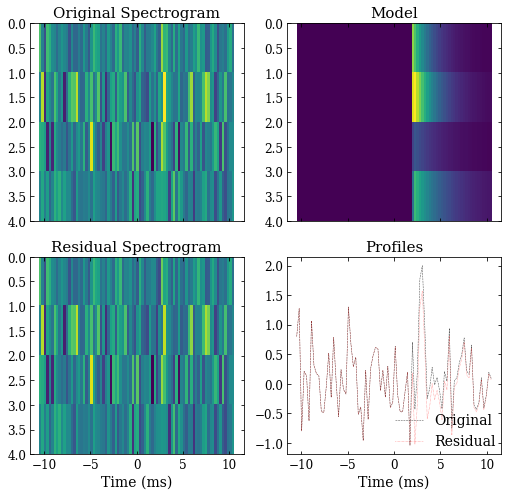

2022-05-26 20:57:20,567 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:20,570 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 20:57:20,575 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 20:57:20,577 - get_off_pulse_region -burstfit.fit - INFO - Using sgram fit parameters.
2022-05-26 20:57:20,580 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:20,583 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 20:57:20,588 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0195705866275606
2022-05-26 20:57:20,589 - fitall -burstfit.fit - INFO - Fixed component exceeded. Terminated individual component fitting.
2022-05-26 20:57:20,591 - fitall -burstfit.fit - INFO - Final number of components 2 > 1. Fitting all components together.
2022-05-26 20:57:20,593 - fit_all_components -burstfit.fit - INFO - Fitting 2 components together.
2022-

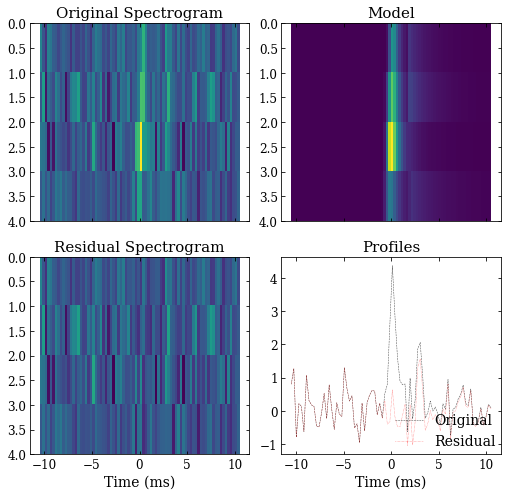

2022-05-26 20:57:21,016 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:21,019 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 20:57:21,023 - get_off_pulse_region -burstfit.fit - INFO - mu_t and sigma_t found in params. Using those to estimate off pulse region.
2022-05-26 20:57:21,026 - get_off_pulse_region -burstfit.fit - INFO - Using sgram all-component-fit parameters.
2022-05-26 20:57:21,028 - model -burstfit.fit - INFO - Making model.
2022-05-26 20:57:21,029 - model -burstfit.fit - INFO - Found 2 components.
2022-05-26 20:57:21,033 - calc_redchisq -burstfit.fit - INFO - Reduced chi-square value of fit is: 1.0195705866275606
2022-05-26 20:57:21,035 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2022-05-26 20:57:21,038 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2022-05-26 20:57:21,043 - tests -root - INFO - P values: T-test (0.10514), Kruskal (0.04541), KS (0.04486), F-test (0.90495)
2022-05-26 20:5

{bf}.calc_redchisq()= 1.0195705866275606


In [13]:
bf_S1T2_c2 = fit_paper_curvefit(data_burst, ['S', 'mu_t', 'sigma_t', 'tau'], pulse_fn, 
          [(0, 45, 0, 0),(np.inf, 65, 10*bd.width, np.inf)], 
          ['c0', 'c1', 'c2'], model_free_normalized_4, fix_ncomp = True, ncomp=2, plot=True)

2022-05-26 20:57:21,086 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2022-05-26 20:57:21,089 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [1.96118605e-01 3.21482097e-01 4.70098605e-01 5.77143658e+01
 3.94364223e+01 8.16644897e-01 1.90535993e+00 6.23425789e+02
 3.07757456e-01 4.80300933e-01 1.49595271e-01 1.89232372e+01
 4.63689060e+01 8.30085364e-02 7.29913693e+00 6.24337019e+02]
2022-05-26 20:57:21,091 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2022-05-26 20:57:21,093 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2022-05-26 20:57:21,095 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2022-05-26 20:57:21,097 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(13.13844647131221) + max_sigma_t_prior(1.4699608140731486))
2022-05-26 20:57:21,0

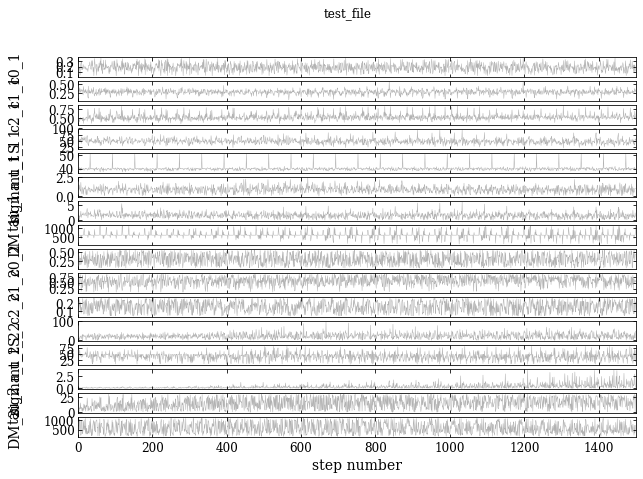

<Figure size 432x288 with 0 Axes>

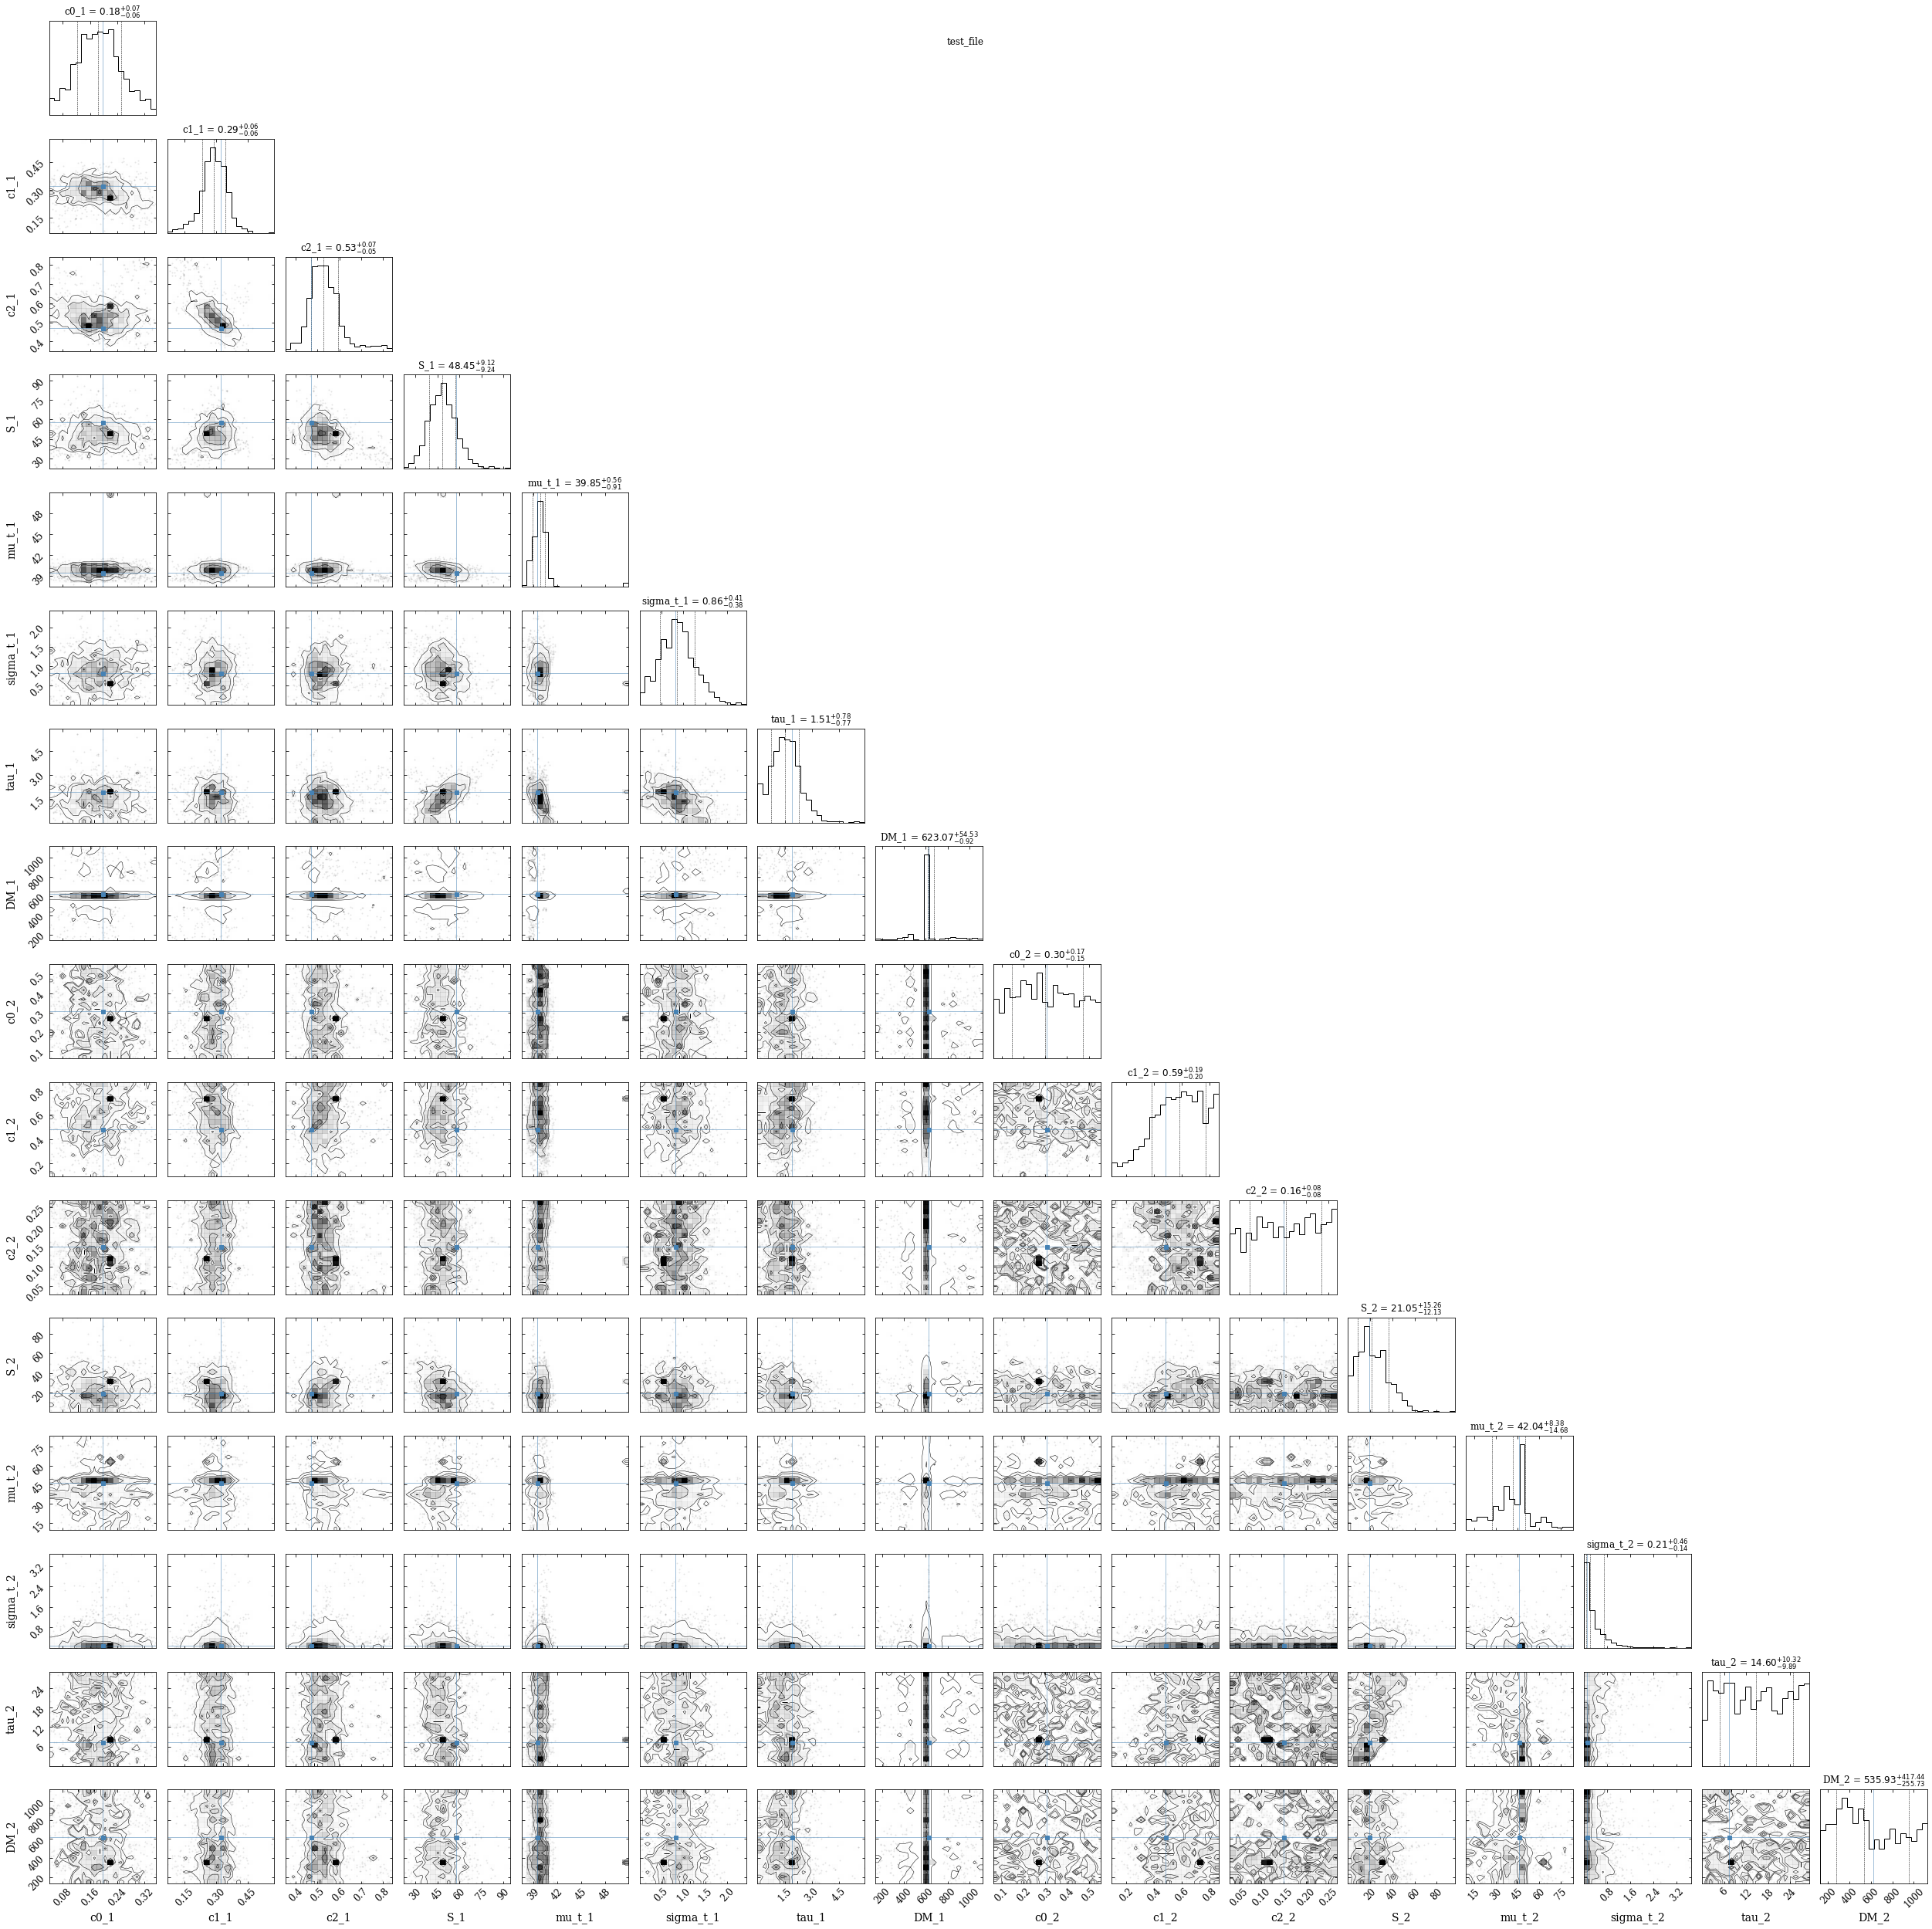

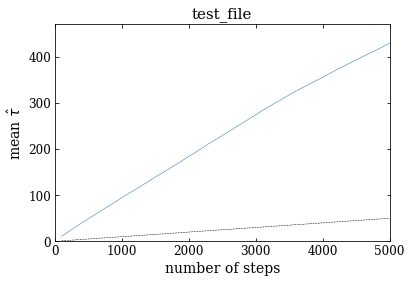

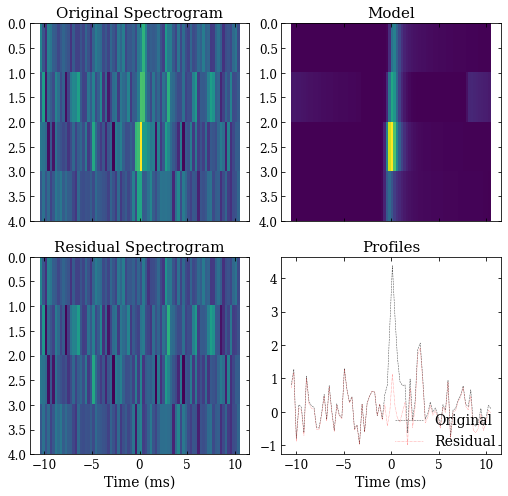

{bf}.bic =  315.34905141906665


0

In [14]:
fit_paper_mcmc_bic(bf_S1T2_c2, mcmc=True)

In [15]:
select_model(["bf_S1T2_c1", "bf_S1T2_c2"])


(['bf_S1T2_c1', 'bf_S1T2_c2'], array([275.75492892, 315.34905142]))

### bf_S1T1_cx: model-free spectrum + gaussian profile NO scattering + x-component 

In [ ]:
# bf_S1T1_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 

pnames = ['S', 'mu_t', 'sigma_t'] # , 'tau'
pulseModel = Model(gauss, param_names=pnames)
#profile_bounds=[(0, 0.5 / bd.tsamp - i_low, 0),(np.inf, 0.52/ bd.tsamp - i_low, 5*bd.width)]
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]


nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf)) # did not work when only set up bounds but do not chop data 
#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf))

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T1_c1 for later model selection 
bf_S1T1_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T1_c1.validate()
bf_S1T1_c1.precalc()


# fit tests
#bf_S1T1_c1.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T1_c1.initial_spectrafit(plot = True)

bf_S1T1_c1.fitcycle(plot=True, profile_bounds = profile_bounds) # fit for one component.
bf_S1T1_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T1_c1.calc_redchisq()=', bf_S1T1_c1.calc_redchisq())

# plot fit for all components 
# plot_fit_results(bf_S1T1_c1.sgram, bf_S1T1_c1.sgram_model.evaluate, bf_S1T1_c1.sgram_params['all'][1]['popt'], 
#                  bf_S1T1_c1.tsamp, bf_S1T1_c1.fch1, bf_S1T1_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T1_c1.sgram_params['all'][1]['popt'][-1], bf_S1T1_c1.sgram_params['all'][1]['perr'][-1]

#bf_S1T1_c1.sgram_params

In [ ]:
# bf_S1T1_c1: single component 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel

ncomp = 1 
nfreq=4

pnames = ['S', 'mu_t', 'sigma_t'] 
pulseModel = Model(gauss, param_names=pnames)
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]


snames = ['c0', 'c1', 'c2'] 
spectraModel = Model(model_free_normalized_4, param_names=snames)


sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf)) # did not work when only set up bounds but do not chop data 
#sgram_bounds=((-np.inf, -np.inf, -np.inf, -np.inf, 0, 0, 0),(np.inf, np.inf, np.inf, np.inf, np.inf, np.shape(data_burst)[1], np.inf))

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T1_c1 for later model selection 
bf_S1T1_c1 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    #comp_num = 1, 
)


# Some setting up before we do the fitting 
bf_S1T1_c1.validate()
bf_S1T1_c1.precalc()


# fit tests
bf_S1T1_c1.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T1_c1.initial_spectrafit(plot = True)

#bf_S1T1_c1.fitcycle(plot=True, profile_bounds = profile_bounds) # fit for one component.
#bf_S1T1_c1.fitall(plot=True, max_ncomp = ncomp) # fit all componnts 
print('bf_S1T1_c1.calc_redchisq()=', bf_S1T1_c1.calc_redchisq())

# plot fit for all components 
# plot_fit_results(bf_S1T1_c1.sgram, bf_S1T1_c1.sgram_model.evaluate, bf_S1T1_c1.sgram_params['all'][1]['popt'], 
#                  bf_S1T1_c1.tsamp, bf_S1T1_c1.fch1, bf_S1T1_c1.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T1_c1.sgram_params['all'][1]['popt'][-1], bf_S1T1_c1.sgram_params['all'][1]['perr'][-1]

#bf_S1T1_c1.sgram_params

In [ ]:
# bf_S1T2_c2: model-free spectrum + gaussian with scattering profile (2 components) 
#data_burst = data[:,int(0.45/bd.tsamp): int(0.55/bd.tsamp)] # change to x * width 
#fit models  
# For pulse, we will use a gaussian convolved with an exponential model 
# S: Area of the pulse (fluence)
# mu: means of gaussians for each channel
# sigma: sigma of gaussian
# tau: scattering timescale for each channel
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
#profile_bounds=[(0, 480, 0, 0),(np.inf, 510, 10*bd.width, np.inf)]
profile_bounds=[(0, 50, 0),(np.inf, 60, 5*bd.width)]

nfreq = 4
# For spectrum, try model-free  
nfreq_model = nfreq # try less 
snames = [0] * nfreq_model

for i in range(nfreq_model):
    snames[i] = 'c'+str(i)

print('snames:', snames)
spectraModel = Model(model_free_4, param_names=snames)
#spectraModel = Model(model_free, param_names=snames)





sgram_mask = np.full(np.shape(data_burst), False)
#sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
#                        mask=sgram_mask, clip_fac=bd.clip_fac, other_param_names=["DM"])

sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn, 
                        mask=sgram_mask, clip_fac=bd.clip_fac)#, other_param_names=["DM"])

#sgram_bounds=((0, 0.45, 0, -np.inf),(np.inf, 0.55, np.inf, np.inf)) # did not work when only set up bounds but do not chop data 

# Provide basic candidate information to `BurstFit`: sgram, model, DM, width, RFI mask, etc 
# initial fit: use heimdall results 
# rename bf_S1T2_c2 for later model selection 
bf_S1T2_c2 = BurstFit(
    sgram_model=sgramModel,
    sgram=data_burst, 
    width=width_heimdall,
    dm=dm_heimdall,
    foff=bd.foff * 1024 / nfreq,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask= sgram_mask, 
    mcmcfit=False,
    comp_num = 2, 
)


# Some setting up before we do the fitting 
bf_S1T2_c2.validate()
bf_S1T2_c2.precalc()


# fit 
#bf_S1T2_c2.initial_profilefit(bounds = profile_bounds, plot = True)
#bf_S1T2_c2.initial_spectrafit(plot = True)

bf_S1T2_c2.fitcycle(plot = True)
# fit all componnts 
bf_S1T2_c2.fitall(plot = True, max_ncomp = bf_S1T2_c2.comp_num + 1) 
bf_S1T2_c2.calc_redchisq()
plot_fit_results(bf_S1T2_c2.sgram, bf_S1T2_c2.sgram_model.evaluate, bf_S1T2_c2.sgram_params['all'][1]['popt'], 
                 bf_S1T2_c2.tsamp, bf_S1T2_c2.fch1, bf_S1T2_c2.foff, show=True, save=True, outname=save_name+'2d_fit_res_curvfit', outdir=save_dir)
#dm_fit, dm_fit_err = bf_S1T2_c2.sgram_params['all'][1]['popt'][-1], bf_S1T2_c2.sgram_params['all'][1]['perr'][-1]

bf_S1T2_c2.sgram_params